In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
import torch.quantization
from tqdm import tqdm 
from torch.nn.utils import prune
# import hls4ml

: 

In [2]:
from matplotlib import font_manager
from cycler import cycler
from matplotlib.font_manager import FontProperties
font_path = '/vols/cms/hw423/Acc/Fonts/ImperialSansText-Regular.ttf'
font_manager.fontManager.addfont(font_path)  # 添加字体路径
font_name = font_manager.FontProperties(fname=font_path).get_name()  # 获取字体名称
plt.rcParams['font.family'] = font_name 
plt.rcParams['axes.prop_cycle'] = cycler(color=['#0000CD', '#7B68EE', '#000080', '#C71585', '#9467bd'])
plt.rcParams['figure.facecolor'] ='#F5F5F5'
plt.rcParams['axes.facecolor'] = '#F5F5F5'

In [3]:
def AUC(model,test_loader):
    model.eval()
    y_pre = []
    y_labe = []
    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, labels in test_loader:
            outputs = model(inputs)
            y_pre=np.append(y_pre,outputs.numpy())
            y_labe=np.append(y_labe,labels.numpy())
    from sklearn.metrics import roc_auc_score
    auc = roc_auc_score(y_labe, y_pre)
    print(f'AUC = {auc}')

# Un-modified Model

- Memory Calculation:
1. Layer 0:
    - Weights: 140 * 32 parameters
    - Biases: 32 parameters
    - Memory: M0 = (140 * 32 + 32) * 4 = 18048 bytes = 18048/1024 KB = 17.625 KB
2. Layer 1: 
    - Weights: 32 * 16 parameters
    - Biases: 16 parameters
    - Memory: M1 = (32 * 16 + 16) * 4 = 2112 bytes = 2.0625 KB
3. Layer 2:
    - Weights: 16 * 1 parameters
    - Biases: 1 parameters
    - Memory: M2 = (16 * 1 + 1) * 4 = 68 bytes 
Memory Calculation for Parameters:
1. Weights: In each layer is the production of the input and output sizes. For biases, it is the output size of the layer.
2. Total Memory: Sum up all weights and biases across all layers and multiply by 4 bytes (for 32-bit precision).

M = 18048 + 2112 + 68 bytes = 19.754 KB


In [5]:
batch = 512

In [6]:
df = pd.read_parquet('df.parquet')
X = pd.read_parquet('x.parquet').values  
df['proc'] = df['proc'].apply(lambda x: 1 if x != 0 else 0)
y = df['proc'].values  

X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_data, batch_size=batch, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch, shuffle=False)


In [7]:
num_epochs = 20
layers = [1024, 512, 128]
lr = 0.001

In [8]:
class BinaryClassificationModel(nn.Module):
    def __init__(self):
        super(BinaryClassificationModel, self).__init__()
        self.layer0 = nn.Linear(X.shape[1], layers[0])
        self.layer1 = nn.Linear(layers[0], layers[1])
        self.layer2 = nn.Linear(layers[1], layers[2])
        self.layer3 = nn.Linear(layers[2], 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        timings = {}

        start_time = time.time()
        x = torch.relu(self.layer0(x))
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        timings['fc_time'] = time.time() - start_time

        x = self.sigmoid(self.layer3(x))
        
        return x, timings['fc_time']
model = BinaryClassificationModel()

In [9]:
def train_model(model, train_loader, lr=0.001, num_epochs=50):
    model.train()
    criterion = nn.BCELoss()  # Combines Sigmoid + BCELoss
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    losses = []
    timing = {'fc_time': 0}

    for epoch in tqdm(range(num_epochs), desc="Epochs"):
        epoch_loss = 0
        for inputs, labels in tqdm(train_loader, desc="Training", leave=False):
            optimizer.zero_grad()
            
            outputs, fc_time = model(inputs)
            
            # Accumulate the timing information
            timing['fc_time'] += fc_time

            # Compute loss
            loss = criterion(outputs.squeeze(), labels.float())
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        losses.append(epoch_loss / len(train_loader))
        # print(f"Epoch {epoch+1}, Loss: {epoch_loss / len(train_loader)}")
    
    return losses, timing, model

In [25]:
# Train the model
losses, timing, model = train_model(model, train_loader, lr=0.001, num_epochs=20)

Epochs: 100%|██████████| 20/20 [25:50<00:00, 77.51s/it] 


In [26]:
timing

{'fc_time': 502.9939477443695}

In [27]:
# save the model
torch.save(model.state_dict(), 'model.pth')

In [72]:
# Assuming `BinaryClassificationModel` is defined and accessible
model = BinaryClassificationModel()

# Load the model state dictionary
model.load_state_dict(torch.load('model.pth'))

<All keys matched successfully>

<All keys matched successfully>


In [29]:
model.eval()
y_pre = []
T = []
for _ in range(200):
    times = 0
    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, labels in test_loader:
            stt= time.time()
            outputs, _ = model(inputs)
            ent = time.time()
            times+=ent-stt
            predicted = (outputs.squeeze() > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            y_pre.append(predicted)
        T.append(times)
T= np.array(T)
accuracy0 = correct / total

print(f'Accuracy: {accuracy0}')
print(f'Predict time: {times}')

Accuracy: 0.91575
Predict time: 6.018877029418945


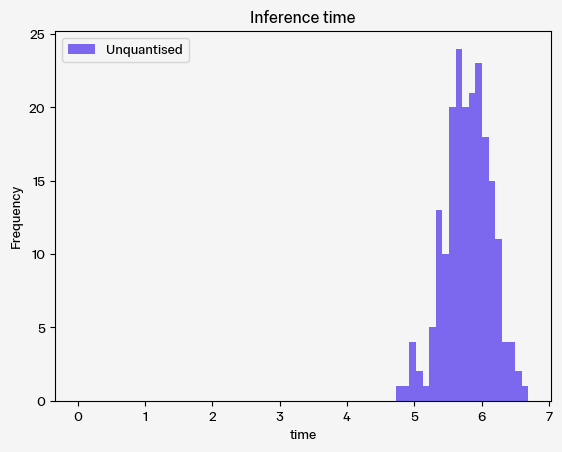

In [31]:
plt.hist([],bins=100,density =False)
plt.hist(T,bins=20,density = False, label = 'Unquantised')
# plt.xlim(0,0.2)
# plt.xscale('log')
plt.title('Inference time')
plt.legend()
plt.ylabel('Frequency')
plt.xlabel('time')
plt.savefig('vt_u.pdf')

In [21]:
y_pre = []
y_labe = []
with torch.no_grad():
    correct = 0
    total = 0
    for inputs, labels in test_loader:
        outputs, _ = model(inputs)
        y_pre=np.append(y_pre,outputs.numpy())
        y_labe=np.append(y_labe,labels.numpy())
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(y_labe, y_pre)
print(f'AUC = {auc}')

AUC = 0.9651988481557991


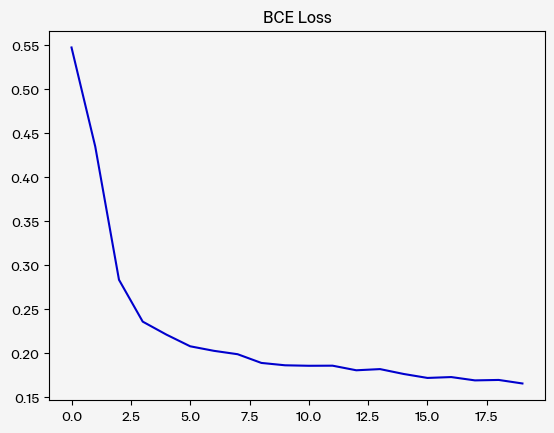

In [25]:
import matplotlib.pyplot as plt
lss = []
for i in range(len(losses)):
    lss.append(losses[i])
plt.plot(lss)
plt.title('BCE Loss')
plt.savefig('Loss.pdf')

## PTQ

In [9]:
model_ptq = BinaryClassificationModel()

In [12]:
# Train the model
losses, timing, model_p = train_model(model_ptq, train_loader, lr=0.001, num_epochs=20)

Epochs: 100%|██████████| 20/20 [17:28<00:00, 52.43s/it]


In [13]:
# save the model
torch.save(model_p.state_dict(), 'model_p.pth')

In [10]:
model_p = BinaryClassificationModel()

# Load the model state dictionary
model_p.load_state_dict(torch.load('model_p.pth'))

<All keys matched successfully>

In [11]:
model_p

BinaryClassificationModel(
  (layer0): Linear(in_features=140, out_features=1024, bias=True)
  (layer1): Linear(in_features=1024, out_features=512, bias=True)
  (layer2): Linear(in_features=512, out_features=128, bias=True)
  (layer3): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [16]:
model_p.eval()
quantized_model = torch.quantization.quantize_dynamic(
    model_p,  
    {nn.Linear},  
    dtype=torch.qint8
)
quantized_model.eval()
QT = []

In [19]:

for _ in range(200):
    correct = 0
    total = 0
    Qtimes = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            stt = time.time()
            outputs, _  = quantized_model(inputs)
            ent = time.time()
            Qtimes+=ent-stt
            predicted = (outputs.squeeze() > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    QT.append(Qtimes)
QT=np.array(QT)
accuracy2 = correct / total
print(f'Accuracy = {accuracy2}')
print(f'Predict time: {Qtimes}')

Accuracy = 0.9083333333333333
Predict time: 0.030799388885498047


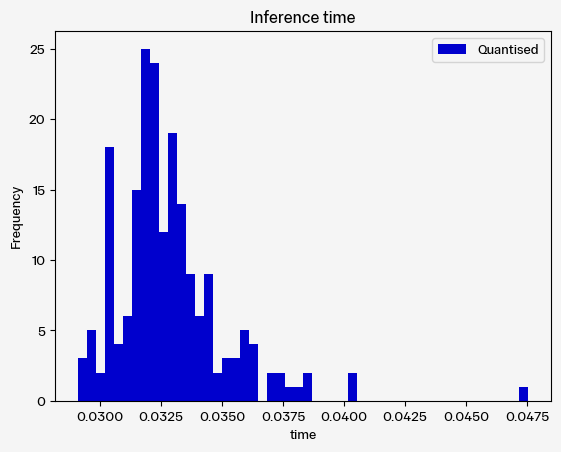

In [20]:
a,b,_= plt.hist(QT[QT<0.05],bins=50,density =False,label = 'Quantised')
# plt.hist(T,bins=b,density = False, label = 'Unquantised')
# plt.xlim(0.006,0.05)
# plt.xscale('log')
plt.title('Inference time')
plt.xlabel('time')
plt.ylabel('Frequency')
plt.legend()
plt.savefig('vt.pdf')

In [12]:
def AUC(model,test_loader):
    model.eval()
    y_pre = []
    y_labe = []
    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, labels in test_loader:
            outputs, _ = model(inputs)
            y_pre=np.append(y_pre,outputs.numpy())
            y_labe=np.append(y_labe,labels.numpy())
    from sklearn.metrics import roc_auc_score
    auc = roc_auc_score(y_labe, y_pre)
    print(f'AUC = {auc}')

In [13]:
AUC(model_p,test_loader)

AUC = 0.9660662181765065


In [17]:
quantized_model

BinaryClassificationModel(
  (layer0): DynamicQuantizedLinear(in_features=140, out_features=1024, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
  (layer1): DynamicQuantizedLinear(in_features=1024, out_features=512, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
  (layer2): DynamicQuantizedLinear(in_features=512, out_features=128, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
  (layer3): DynamicQuantizedLinear(in_features=128, out_features=1, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
  (sigmoid): Sigmoid()
)

In [71]:
# Define the number of features for each Linear layer
in_features = [140, 64, 32, 16]
out_features = [64, 32, 16, 1]

# Calculate the total memory for weights (in bytes)
# Since these are not quantized, we assume float32, which is 4 bytes per weight
total_weights_memory = sum(in_f * out_f * 4 for in_f, out_f in zip(in_features, out_features))

# Calculate the total memory for biases (in bytes)
# Each bias also uses 4 bytes (for float32)
total_biases_memory = sum(out_f * 4 for out_f in out_features)

# Total memory used by the model (in bytes)
total_model_memory_bytes = total_weights_memory + total_biases_memory

total_model_memory_bytes / 1024

45.50390625

## QAT

In [44]:
num_epochs = 20
layers = [64, 32, 16]

In [53]:
class BinaryClassificationModelQ(nn.Module):
    def __init__(self):
        super(BinaryClassificationModelQ, self).__init__()
        self.quant = torch.quantization.QuantStub()
        self.layer0 = nn.Linear(X.shape[1], layers[0])
        self.layer1 = nn.Linear(layers[0], layers[1])
        self.layer2 = nn.Linear(layers[1], layers[2])
        self.layer3 = nn.Linear(layers[2], 1)
        self.sigmoid = nn.Sigmoid()
        self.dequant = torch.quantization.DeQuantStub()
    
    def forward(self, x):
        timings = {}
        
        start_time = time.time()
        x = self.quant(x)
        timings['quant_time'] = time.time() - start_time

        start_time = time.time()
        x = torch.relu(self.layer0(x))
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        timings['fc_time'] = time.time() - start_time

        start_time = time.time()
        x = self.sigmoid(self.layer3(x))
        x = self.dequant(x)
        timings['dequant_time'] = time.time() - start_time

        return x, timings['quant_time'], timings['fc_time'], timings['dequant_time']

modelQ = BinaryClassificationModelQ()
modelQ.qconfig = torch.quantization.get_default_qat_qconfig('fbgemm')
torch.quantization.prepare_qat(modelQ, inplace=True)


/vols/cms/yhe4823/Acc/env/envs/env/lib/python3.11/site-packages/torch/ao/quantization/observer.py:214: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


BinaryClassificationModelQ(
  (quant): QuantStub(
    (activation_post_process): FusedMovingAvgObsFakeQuantize(
      fake_quant_enabled=tensor([1]), observer_enabled=tensor([1]), scale=tensor([1.]), zero_point=tensor([0], dtype=torch.int32), dtype=torch.quint8, quant_min=0, quant_max=127, qscheme=torch.per_tensor_affine, reduce_range=True
      (activation_post_process): MovingAverageMinMaxObserver(min_val=inf, max_val=-inf)
    )
  )
  (layer0): Linear(
    in_features=140, out_features=64, bias=True
    (weight_fake_quant): FusedMovingAvgObsFakeQuantize(
      fake_quant_enabled=tensor([1]), observer_enabled=tensor([1]), scale=tensor([1.]), zero_point=tensor([0], dtype=torch.int32), dtype=torch.qint8, quant_min=-128, quant_max=127, qscheme=torch.per_channel_symmetric, reduce_range=False
      (activation_post_process): MovingAveragePerChannelMinMaxObserver(min_val=tensor([]), max_val=tensor([]))
    )
    (activation_post_process): FusedMovingAvgObsFakeQuantize(
      fake_quant_ena

In [60]:
def train_model(model, train_loader, lr=0.001, num_epochs=50):
    model.train()
    criterion = nn.BCELoss()  # Combines Sigmoid + BCELoss
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    losses = []
    timing = {'quant_time': 0, 'fc_time': 0, 'dequant_time': 0}

    for epoch in tqdm(range(num_epochs), desc="Epochs"):
        epoch_loss = 0
        for inputs, labels in tqdm(train_loader, desc="Training", leave=False):
            optimizer.zero_grad()
            
            outputs, quant_time, fc_time,dequant_time = model(inputs)
            
            # Accumulate the timing information
            timing['quant_time'] += quant_time
            timing['fc_time'] += fc_time
            timing['dequant_time'] += dequant_time

            # Compute loss
            loss = criterion(outputs.squeeze(), labels.float())
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        losses.append(epoch_loss / len(train_loader))
        print(f"Epoch {epoch+1}, Loss: {epoch_loss / len(train_loader)}")
    
    return losses, timing, model

In [50]:
# Train the model
losses, timing, model_qat = train_model(modelQ, train_loader, lr=0.001, num_epochs=20)

Epochs:   5%|▌         | 1/20 [00:30<09:41, 30.60s/it]

Epoch 1, Loss: 0.6770993889646327


Epochs:  10%|█         | 2/20 [00:58<08:45, 29.19s/it]

Epoch 2, Loss: 0.6300197364167964


Epochs:  15%|█▌        | 3/20 [01:27<08:13, 29.03s/it]

Epoch 3, Loss: 0.5529150414340039


Epochs:  20%|██        | 4/20 [01:57<07:47, 29.23s/it]

Epoch 4, Loss: 0.5231283563882747


Epochs:  25%|██▌       | 5/20 [02:17<06:28, 25.88s/it]

Epoch 5, Loss: 0.5116599833077573


Epochs:  30%|███       | 6/20 [02:34<05:22, 23.05s/it]

Epoch 6, Loss: 0.511191650590998


Epochs:  35%|███▌      | 7/20 [02:54<04:45, 21.93s/it]

Epoch 7, Loss: 0.5050710065567747


Epochs:  40%|████      | 8/20 [03:10<04:02, 20.18s/it]

Epoch 8, Loss: 0.5006748726393314


Epochs:  45%|████▌     | 9/20 [03:29<03:36, 19.66s/it]

Epoch 9, Loss: 0.4960322785884776


Epochs:  50%|█████     | 10/20 [03:47<03:12, 19.23s/it]

Epoch 10, Loss: 0.4920148599020978


Epochs:  55%|█████▌    | 11/20 [04:05<02:48, 18.75s/it]

Epoch 11, Loss: 0.48331573161673036


Epochs:  60%|██████    | 12/20 [04:24<02:32, 19.06s/it]

Epoch 12, Loss: 0.460729274343937


Epochs:  65%|██████▌   | 13/20 [04:42<02:10, 18.64s/it]

Epoch 13, Loss: 0.42578001035020707


Epochs:  70%|███████   | 14/20 [04:59<01:48, 18.16s/it]

Epoch 14, Loss: 0.364459198840121


Epochs:  75%|███████▌  | 15/20 [05:17<01:30, 18.01s/it]

Epoch 15, Loss: 0.3236592754404596


Epochs:  80%|████████  | 16/20 [05:34<01:11, 17.80s/it]

Epoch 16, Loss: 0.3008267732059702


Epochs:  85%|████████▌ | 17/20 [05:52<00:53, 17.82s/it]

Epoch 17, Loss: 0.27787219796408996


Epochs:  90%|█████████ | 18/20 [06:11<00:36, 18.12s/it]

Epoch 18, Loss: 1.5259761778598135


Epochs:  95%|█████████▌| 19/20 [06:28<00:17, 17.82s/it]

Epoch 19, Loss: 2.071602241790041


Epochs: 100%|██████████| 20/20 [06:45<00:00, 20.28s/it]


Epoch 20, Loss: 2.071371963683595


In [51]:
print(timing)

{'quant_time': 55.34764337539673, 'fc_time': 153.7611107826233, 'dequant_time': 1.524585485458374}


In [52]:
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim

def train_model(model, train_loader, val_loader, lr=0.001, num_epochs=50, patience=5):
    model.train()
    criterion = nn.BCELoss()  # Combines Sigmoid + BCELoss
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    losses = []
    val_losses = []  # To track validation loss for early stopping
    timing = {'quant_time': 0, 'fc_time': 0, 'dequant_time': 0}
    best_val_loss = float('inf')
    epochs_no_improve = 0  # Track epochs with no improvement

    for epoch in tqdm(range(num_epochs), desc="Epochs"):
        epoch_loss = 0
        model.train()  # Ensure model is in training mode
        for inputs, labels in tqdm(train_loader, desc="Training", leave=False):
            optimizer.zero_grad()
            
            outputs, quant_time, fc_time,dequant_time = model(inputs)
            
            # Accumulate the timing information
            timing['quant_time'] += quant_time
            timing['fc_time'] += fc_time
            timing['dequant_time'] += dequant_time

            # Compute loss
            loss = criterion(outputs.squeeze(), labels.float())
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        losses.append(epoch_loss / len(train_loader))
        print(f"Epoch {epoch+1}, Loss: {epoch_loss / len(train_loader)}")

        # Validation phase
        model.eval()  # Switch to evaluation mode for validation
        val_loss = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs, _, _, _ = model(inputs)
                loss = criterion(outputs.squeeze(), labels.float())
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        print(f"Validation Loss: {avg_val_loss}")

        # Check for early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
            # Save the best model
            best_model = model
        else:
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                print(f"Early stopping triggered after {epoch + 1} epochs.")
                break  # Stop training

    return losses, val_losses, timing, best_model


In [55]:
L, V, T, B = train_model(modelQ, train_loader, test_loader, lr=0.001, num_epochs=20, patience=5)

Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1, Loss: 0.6632636056301442


Epochs:   5%|▌         | 1/20 [00:20<06:24, 20.22s/it]

Validation Loss: 0.6749265938997269


Epoch 2, Loss: 0.7317377417645556


Epochs:  10%|█         | 2/20 [00:40<06:03, 20.19s/it]

Validation Loss: 0.8558924421668053


Epoch 3, Loss: 1.1041346059200612


Epochs:  15%|█▌        | 3/20 [01:03<06:05, 21.52s/it]

Validation Loss: 1.4638294130563736


Epoch 4, Loss: 1.8746333566117794


Epochs:  20%|██        | 4/20 [01:24<05:41, 21.37s/it]

Validation Loss: 2.087880219022433


Epoch 5, Loss: 2.07213978691304


Epochs:  25%|██▌       | 5/20 [01:45<05:17, 21.15s/it]

Validation Loss: 2.0878799011309943


Epoch 6, Loss: 2.071257009151134


Epochs:  25%|██▌       | 5/20 [02:05<06:16, 25.08s/it]

Validation Loss: 2.087879573305448
Early stopping triggered after 6 epochs.


In [23]:
# save the model
torch.save(model_qat.state_dict(), 'model_q.pth')

In [40]:
# load the model 
model_q = BinaryClassificationModelQ()
model_q.load_state_dict(torch.load('model_q.pth'))

RuntimeError: Error(s) in loading state_dict for BinaryClassificationModelQ:
	Unexpected key(s) in state_dict: "quant.activation_post_process.fake_quant_enabled", "quant.activation_post_process.observer_enabled", "quant.activation_post_process.scale", "quant.activation_post_process.zero_point", "quant.activation_post_process.activation_post_process.eps", "quant.activation_post_process.activation_post_process.min_val", "quant.activation_post_process.activation_post_process.max_val", "layer0.weight_fake_quant.fake_quant_enabled", "layer0.weight_fake_quant.observer_enabled", "layer0.weight_fake_quant.scale", "layer0.weight_fake_quant.zero_point", "layer0.weight_fake_quant.activation_post_process.eps", "layer0.weight_fake_quant.activation_post_process.min_val", "layer0.weight_fake_quant.activation_post_process.max_val", "layer0.activation_post_process.fake_quant_enabled", "layer0.activation_post_process.observer_enabled", "layer0.activation_post_process.scale", "layer0.activation_post_process.zero_point", "layer0.activation_post_process.activation_post_process.eps", "layer0.activation_post_process.activation_post_process.min_val", "layer0.activation_post_process.activation_post_process.max_val", "layer1.weight_fake_quant.fake_quant_enabled", "layer1.weight_fake_quant.observer_enabled", "layer1.weight_fake_quant.scale", "layer1.weight_fake_quant.zero_point", "layer1.weight_fake_quant.activation_post_process.eps", "layer1.weight_fake_quant.activation_post_process.min_val", "layer1.weight_fake_quant.activation_post_process.max_val", "layer1.activation_post_process.fake_quant_enabled", "layer1.activation_post_process.observer_enabled", "layer1.activation_post_process.scale", "layer1.activation_post_process.zero_point", "layer1.activation_post_process.activation_post_process.eps", "layer1.activation_post_process.activation_post_process.min_val", "layer1.activation_post_process.activation_post_process.max_val", "layer2.weight_fake_quant.fake_quant_enabled", "layer2.weight_fake_quant.observer_enabled", "layer2.weight_fake_quant.scale", "layer2.weight_fake_quant.zero_point", "layer2.weight_fake_quant.activation_post_process.eps", "layer2.weight_fake_quant.activation_post_process.min_val", "layer2.weight_fake_quant.activation_post_process.max_val", "layer2.activation_post_process.fake_quant_enabled", "layer2.activation_post_process.observer_enabled", "layer2.activation_post_process.scale", "layer2.activation_post_process.zero_point", "layer2.activation_post_process.activation_post_process.eps", "layer2.activation_post_process.activation_post_process.min_val", "layer2.activation_post_process.activation_post_process.max_val", "layer3.weight_fake_quant.fake_quant_enabled", "layer3.weight_fake_quant.observer_enabled", "layer3.weight_fake_quant.scale", "layer3.weight_fake_quant.zero_point", "layer3.weight_fake_quant.activation_post_process.eps", "layer3.weight_fake_quant.activation_post_process.min_val", "layer3.weight_fake_quant.activation_post_process.max_val", "layer3.activation_post_process.fake_quant_enabled", "layer3.activation_post_process.observer_enabled", "layer3.activation_post_process.scale", "layer3.activation_post_process.zero_point", "layer3.activation_post_process.activation_post_process.eps", "layer3.activation_post_process.activation_post_process.min_val", "layer3.activation_post_process.activation_post_process.max_val", "sigmoid.activation_post_process.fake_quant_enabled", "sigmoid.activation_post_process.observer_enabled", "sigmoid.activation_post_process.scale", "sigmoid.activation_post_process.zero_point", "sigmoid.activation_post_process.activation_post_process.scale", "sigmoid.activation_post_process.activation_post_process.zero_point". 

In [31]:
model_qat

BinaryClassificationModelQ(
  (quant): QuantStub(
    (activation_post_process): FusedMovingAvgObsFakeQuantize(
      fake_quant_enabled=tensor([1]), observer_enabled=tensor([1]), scale=tensor([0.2662]), zero_point=tensor([30], dtype=torch.int32), dtype=torch.quint8, quant_min=0, quant_max=127, qscheme=torch.per_tensor_affine, reduce_range=True
      (activation_post_process): MovingAverageMinMaxObserver(min_val=-8.115145683288574, max_val=25.695375442504883)
    )
  )
  (layer0): Linear(
    in_features=140, out_features=1024, bias=True
    (weight_fake_quant): FusedMovingAvgObsFakeQuantize(
      fake_quant_enabled=tensor([1]), observer_enabled=tensor([1]), scale=tensor([6.1000e-05, 6.1000e-05, 6.1000e-05,  ..., 6.1000e-05, 6.1000e-05,
              6.1000e-05]), zero_point=tensor([0, 0, 0,  ..., 0, 0, 0], dtype=torch.int32), dtype=torch.qint8, quant_min=-128, quant_max=127, qscheme=torch.per_channel_symmetric, reduce_range=False
      (activation_post_process): MovingAveragePerChann

In [26]:
model_qat.eval()
y_pre = []
T = []
for _ in range(200):
    times = 0
    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, labels in test_loader:
            stt= time.time()
            outputs, _, _, _ = model_qat(inputs)
            ent = time.time()
            times+=ent-stt
            predicted = (outputs.squeeze() > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            y_pre.append(predicted)
        T.append(times)
T= np.array(T)
accuracy0 = correct / total

print(f'Accuracy: {accuracy0}')
print(f'Predict time: {times}')

Accuracy: 0.62325
Predict time: 10.143555164337158


In [27]:
# Save T:
np.save('T_qat.npy', T)

In [28]:
# load the data
T_qat = np.load('T_qat.npy')

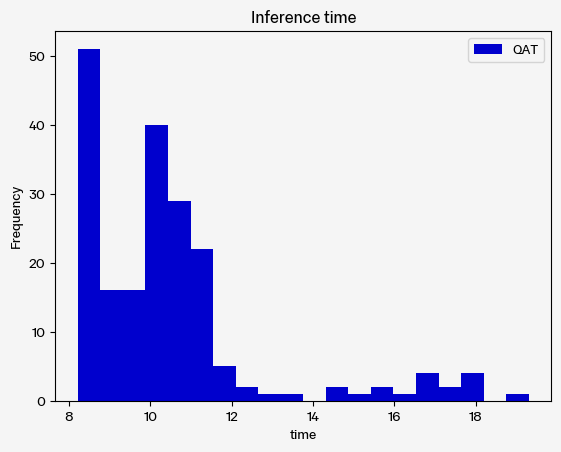

In [69]:
# plt.hist([],bins=100,density =False)
plt.hist(T_qat,bins=20,density = False, label = 'QAT')
# plt.xlim(0,0.2)
# plt.xscale('log')
plt.title('Inference time')
plt.legend()
plt.ylabel('Frequency')
plt.xlabel('time')
plt.savefig('vt_qat.pdf')

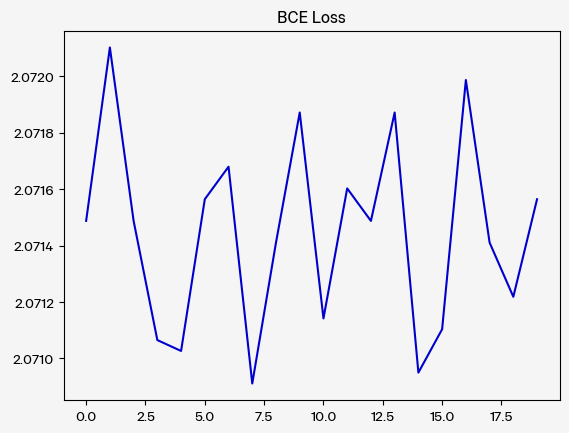

In [30]:
import matplotlib.pyplot as plt
lss = []
for i in range(len(losses)):
    lss.append(losses[i])
plt.plot(lss)
plt.title('BCE Loss')
plt.savefig('Loss.pdf')

In [35]:
model_qat.eval()
model_qat.qconfig = torch.quantization.get_default_qconfig('fbgemm')
model_qat_prepared = torch.quantization.prepare(model_qat, inplace=False)
quantized_model = torch.quantization.convert(model_qat_prepared, inplace=False)
quantized_model.eval()

/vols/cms/yhe4823/Acc/env/envs/env/lib/python3.11/site-packages/torch/ao/quantization/observer.py:214: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


BinaryClassificationModelQ(
  (quant): Quantize(scale=tensor([0.2662]), zero_point=tensor([30]), dtype=torch.quint8)
  (layer0): QuantizedLinear(in_features=140, out_features=1024, scale=0.04846855625510216, zero_point=0, qscheme=torch.per_channel_affine)
  (layer1): QuantizedLinear(in_features=1024, out_features=512, scale=0.03324233740568161, zero_point=0, qscheme=torch.per_channel_affine)
  (layer2): QuantizedLinear(in_features=512, out_features=128, scale=0.019744284451007843, zero_point=0, qscheme=torch.per_channel_affine)
  (layer3): QuantizedLinear(in_features=128, out_features=1, scale=0.10634245723485947, zero_point=0, qscheme=torch.per_channel_affine)
  (sigmoid): Sigmoid()
  (dequant): DeQuantize()
)

In [36]:

for _ in range(200):
    correct = 0
    total = 0
    Qtimes = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            stt = time.time()
            outputs, _,  _ , _ = quantized_model(inputs)
            ent = time.time()
            Qtimes+=ent-stt
            predicted = (outputs.squeeze() > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    QT.append(Qtimes)
QT=np.array(QT)
accuracy2 = correct / total
print(f'Accuracy = {accuracy2}')
print(f'Predict time: {Qtimes}')

Accuracy = 0.62325
Predict time: 0.0633857250213623


In [37]:
# Save T:
np.save('T_qq.npy', QT)

In [ ]:
# load the data
T_qq = np.load('T_qq.npy')

NameError: name 'T_qq' is not defined

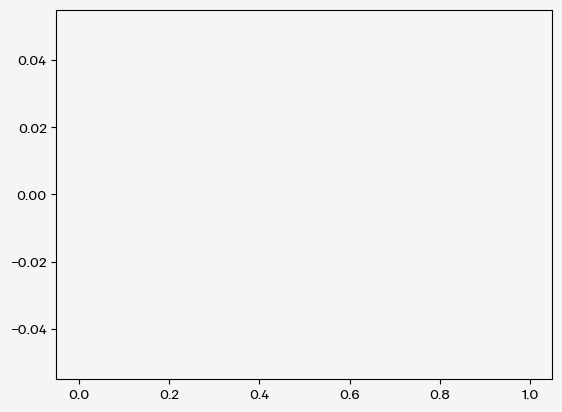

In [66]:
plt.hist([],bins=100,density =False)
plt.hist(T_qq,bins=20,density = False, label = 'QAT')
# plt.xlim(0,0.2)
# plt.xscale('log')
plt.title('Inference time')
plt.legend()
plt.ylabel('Frequency')
plt.xlabel('time')
plt.savefig('vt_qat.pdf')

In [32]:
model_qat.eval()
quantized_model = torch.quantization.quantize_dynamic(
    model_qat,  
    {nn.Linear},  
    dtype=torch.qint8
)
quantized_model.eval()
QT = []

/vols/cms/yhe4823/Acc/env/envs/env/lib/python3.11/site-packages/torch/ao/quantization/observer.py:214: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


In [34]:

for _ in range(200):
    correct = 0
    total = 0
    Qtimes = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            stt = time.time()
            outputs, _,  _ , _ = quantized_model(inputs)
            ent = time.time()
            Qtimes+=ent-stt
            predicted = (outputs.squeeze() > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    QT.append(Qtimes)
QT=np.array(QT)
accuracy2 = correct / total
print(f'Accuracy = {accuracy2}')
print(f'Predict time: {Qtimes}')

AttributeError: 'FusedMovingAvgObsFakeQuantize' object has no attribute 'activation_post_process'

In [62]:
batch = 1024

df = pd.read_parquet('df.parquet')
X = pd.read_parquet('x.parquet').values  
df['proc'] = df['proc'].apply(lambda x: 1 if x != 0 else 0)
y = df['proc'].values  

X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_data, batch_size=batch, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch, shuffle=False)


In [63]:
num_epochs = 20
layers = [1024, 512, 128]
lr = 0.001

In [64]:
class BinaryClassificationModelQ(nn.Module):
    def __init__(self):
        super(BinaryClassificationModelQ, self).__init__()
        self.quant = torch.quantization.QuantStub()
        self.layer0 = nn.Linear(X.shape[1], layers[0])
        self.layer1 = nn.Linear(layers[0], layers[1])
        self.layer2 = nn.Linear(layers[1], layers[2])
        self.layer3 = nn.Linear(layers[2], 1)
        self.sigmoid = nn.Sigmoid()
        self.dequant = torch.quantization.DeQuantStub()
    
    def forward(self, x):
        timings = {}
        
        start_time = time.time()
        x = self.quant(x)
        timings['quant_time'] = time.time() - start_time

        start_time = time.time()
        x = torch.relu(self.layer0(x))
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        timings['fc_time'] = time.time() - start_time

        start_time = time.time()
        x = self.sigmoid(self.layer3(x))
        x = self.dequant(x)
        timings['dequant_time'] = time.time() - start_time

        return x, timings['quant_time'], timings['fc_time'], timings['dequant_time']

modelQ = BinaryClassificationModelQ()
modelQ.qconfig = torch.quantization.get_default_qat_qconfig('fbgemm')
torch.quantization.prepare_qat(modelQ, inplace=True)


/vols/cms/yhe4823/Acc/env/envs/env/lib/python3.11/site-packages/torch/ao/quantization/observer.py:214: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


BinaryClassificationModelQ(
  (quant): QuantStub(
    (activation_post_process): FusedMovingAvgObsFakeQuantize(
      fake_quant_enabled=tensor([1]), observer_enabled=tensor([1]), scale=tensor([1.]), zero_point=tensor([0], dtype=torch.int32), dtype=torch.quint8, quant_min=0, quant_max=127, qscheme=torch.per_tensor_affine, reduce_range=True
      (activation_post_process): MovingAverageMinMaxObserver(min_val=inf, max_val=-inf)
    )
  )
  (layer0): Linear(
    in_features=140, out_features=1024, bias=True
    (weight_fake_quant): FusedMovingAvgObsFakeQuantize(
      fake_quant_enabled=tensor([1]), observer_enabled=tensor([1]), scale=tensor([1.]), zero_point=tensor([0], dtype=torch.int32), dtype=torch.qint8, quant_min=-128, quant_max=127, qscheme=torch.per_channel_symmetric, reduce_range=False
      (activation_post_process): MovingAveragePerChannelMinMaxObserver(min_val=tensor([]), max_val=tensor([]))
    )
    (activation_post_process): FusedMovingAvgObsFakeQuantize(
      fake_quant_e

In [65]:
# Train the model

losses, timing, model_qat = train_model(modelQ, train_loader, lr=0.001, num_epochs=20)

Epochs:   5%|▌         | 1/20 [00:34<10:47, 34.08s/it]

Epoch 1, Loss: 0.7136371630303403


Epochs:  10%|█         | 2/20 [01:11<10:46, 35.92s/it]

Epoch 2, Loss: 1.5702622748435813


Epochs:  15%|█▌        | 3/20 [01:45<09:54, 34.98s/it]

Epoch 3, Loss: 2.0709333698800267


Epochs:  20%|██        | 4/20 [02:19<09:16, 34.80s/it]

Epoch 4, Loss: 2.0712458706916648


Epochs:  25%|██▌       | 5/20 [02:55<08:46, 35.07s/it]

Epoch 5, Loss: 2.07147615513903


Epochs:  30%|███       | 6/20 [03:28<08:04, 34.60s/it]

Epoch 6, Loss: 2.0717558531050986


Epochs:  35%|███▌      | 7/20 [04:03<07:31, 34.75s/it]

Epoch 7, Loss: 2.07114729221831


Epochs:  40%|████      | 8/20 [04:37<06:53, 34.50s/it]

Epoch 8, Loss: 2.071393979356644


Epochs:  45%|████▌     | 9/20 [05:13<06:23, 34.83s/it]

Epoch 9, Loss: 2.0714104277022343


Epochs:  50%|█████     | 10/20 [05:48<05:48, 34.82s/it]

Epoch 10, Loss: 2.071772364859885


Epochs:  55%|█████▌    | 11/20 [06:22<05:11, 34.61s/it]

Epoch 11, Loss: 2.0715255737304688


Epochs:  60%|██████    | 12/20 [06:57<04:38, 34.86s/it]

Epoch 12, Loss: 2.0709334916256843


Epochs:  65%|██████▌   | 13/20 [07:33<04:04, 34.97s/it]

Epoch 13, Loss: 2.0717229335866074


Epochs:  65%|██████▌   | 13/20 [07:58<04:17, 36.79s/it]


KeyboardInterrupt: 

In [41]:
def eval(model):
    model.eval()  # Set the model to evaluation mode
    start_time = time.time()

    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, labels in test_loader:
            outputs, _, _, _ = model(inputs)
            predicted = torch.round(torch.sigmoid(outputs))
            total += labels.size(0)
            correct += (predicted.squeeze() == labels).sum().item()

    end_time = time.time()  # End time
    evaluation_time = end_time - start_time

    accuracy = correct / total
    print(f'Accuracy: {accuracy}')
    print(f'Time: {evaluation_time}s')
    
    return accuracy, evaluation_time

In [42]:
accQ, tQ = eval(model_qat)

Accuracy: 0.89975
Time: 4.110225439071655s


# Quantisation

In [27]:
class BinaryClassificationModelQ(nn.Module):
    def __init__(self, num_features, mask_size=None, mask=None):
        super(BinaryClassificationModelQ, self).__init__()
        self.quant = torch.quantization.QuantStub()
        self.layer0 = nn.Linear(num_features, layers[0])
        self.layer1 = nn.Linear(layers[0], layers[1])
        self.layer2 = nn.Linear(layers[1], 1)
        self.sigmoid = nn.Sigmoid()
        self.dequant = torch.quantization.DeQuantStub()

    def forward(self, x):
        timings = {}
        
        start_time = time.time()
        x = self.quant(x)
        timings['quant_time'] = time.time() - start_time

        start_time = time.time()
        x = torch.relu(self.layer0(x))
        x = torch.relu(self.layer1(x))
        x = self.sigmoid(self.layer2(x))
        timings['fc_time'] = time.time() - start_time

        start_time = time.time()
        x = self.dequant(x)
        timings['dequant_time'] = time.time() - start_time

        return x, timings['quant_time'], timings['fc_time'], timings['dequant_time']

modelQ = BinaryClassificationModelQ(X.shape[1])
modelQ.qconfig = torch.quantization.get_default_qat_qconfig('fbgemm')
torch.quantization.prepare_qat(modelQ, inplace=True)


BinaryClassificationModelQ(
  (quant): QuantStub(
    (activation_post_process): FusedMovingAvgObsFakeQuantize(
      fake_quant_enabled=tensor([1]), observer_enabled=tensor([1]), scale=tensor([1.]), zero_point=tensor([0], dtype=torch.int32), dtype=torch.quint8, quant_min=0, quant_max=127, qscheme=torch.per_tensor_affine, reduce_range=True
      (activation_post_process): MovingAverageMinMaxObserver(min_val=inf, max_val=-inf)
    )
  )
  (layer0): Linear(
    in_features=140, out_features=32, bias=True
    (weight_fake_quant): FusedMovingAvgObsFakeQuantize(
      fake_quant_enabled=tensor([1]), observer_enabled=tensor([1]), scale=tensor([1.]), zero_point=tensor([0], dtype=torch.int32), dtype=torch.qint8, quant_min=-128, quant_max=127, qscheme=torch.per_channel_symmetric, reduce_range=False
      (activation_post_process): MovingAveragePerChannelMinMaxObserver(min_val=tensor([]), max_val=tensor([]))
    )
    (activation_post_process): FusedMovingAvgObsFakeQuantize(
      fake_quant_ena

In [28]:
def train_model(model, train_loader, lr=0.001, num_epochs=50):
    model.train()
    criterion = nn.BCEWithLogitsLoss()  # Combines Sigmoid + BCELoss
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    losses = []
    timing = {'quant_time': 0, 'fc_time': 0, 'dequant_time': 0}

    for epoch in tqdm(range(num_epochs), desc="Epochs"):
        epoch_loss = 0
        for inputs, labels in tqdm(train_loader, desc="Training", leave=False):
            optimizer.zero_grad()
            
            outputs, quant_time, fc_time,dequant_time = model(inputs)
            
            # Accumulate the timing information
            timing['quant_time'] += quant_time
            timing['fc_time'] += fc_time
            timing['dequant_time'] += dequant_time

            # Compute loss
            loss = criterion(outputs.squeeze(), labels.float())
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        losses.append(epoch_loss / len(train_loader))
        # print(f"Epoch {epoch+1}, Loss: {epoch_loss / len(train_loader)}")
    
    return losses, timing, model

In [29]:
# Train the model
losses, timing, model_qat = train_model(modelQ, train_loader, lr=0.001, num_epochs=50)

Epochs: 100%|██████████| 50/50 [07:41<00:00,  9.23s/it]

Timing: {'quant_time': 47.3816077709198, 'fc_time': 167.51681351661682, 'dequant_time': 0.04328298568725586}


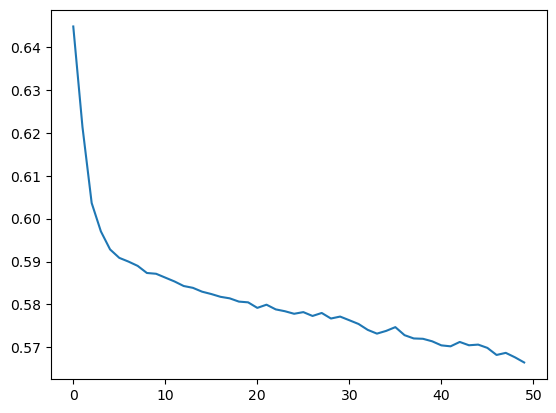

In [35]:
plt.plot(losses)

In [31]:
timing

{'quant_time': 47.3816077709198,
 'fc_time': 167.51681351661682,
 'dequant_time': 0.04328298568725586}

In [37]:
model_qat.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Evaluating"):
        outputs, _, _, _ =  model_qat(inputs)
        predicted = torch.round(torch.sigmoid(outputs))
        total += labels.size(0)
        correct += (predicted.squeeze() == labels).sum().item()

accuracy = correct / total
print(f"Accuracy: {accuracy * 100:.2f}%")


Evaluating: 100%|██████████| 12/12 [00:02<00:00,  5.03it/s]

Accuracy: 66.02%


In [14]:
y_pre = []
y_labe = []
with torch.no_grad():
    correct = 0
    total = 0
    for inputs, labels in test_loader:
        outputs = modelQ(inputs)
        y_pre=np.append(y_pre,outputs.numpy())
        y_labe=np.append(y_labe,labels.numpy())
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(y_labe, y_pre)
print(f'AUC = {auc}')

AUC = 0.8446474577685765


In [38]:
import os
def model_size(model, label=' '):
    torch.save(model_qat.state_dict(),"/vols/cms/yhe4823/Acc/mymodel.p")
    size = os.path.getsize("/vols/cms/yhe4823/Acc/mymodel.p")
    print("model:",label,'\t','Size(KB):',size/1e3)
    os.remove("/vols/cms/yhe4823/Acc/mymodel.p")
    return size
# compare the size
f = model_size(model, "fp32")
q = model_size(model_qat, "int8")
print("{0:.2f} times smaller".format(f/q))

model: fp32 	 Size(KB): 40.564
model: int8 	 Size(KB): 40.564
1.00 times smaller


# Post


In [27]:
model_p = BinaryClassificationModel()

In [ ]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

losses = []
stt = time.time()
with tqdm(range(num_epochs)) as t:
    for epoch in t:
        for inputs, labels in train_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            
            optimizer.zero_grad()
            loss.backward()
            
            optimizer.step()
        losses.append(loss)
        t.set_postfix(train_loss=loss.item())

# Bitwise Encoding:


In [12]:
class BitMask(nn.Module):
    def __init__(self, size, mask=None):
        super(BitMask, self).__init__()
        if mask is None:
            self.mask = torch.ones(size, dtype=torch.float32)
        else:
            assert mask.size() == size
            self.mask = mask

    def forward(self, x):
        return x * self.mask

In [17]:
class BinaryClassificationModelB(nn.Module):
    def __init__(self, num_features, mask_size=None, mask=None):
        super(BinaryClassificationModelB, self).__init__()
        self.layer0 = nn.Linear(num_features, layers[0])
        self.layer1 = nn.Linear(layers[0], layers[1])
        self.bitmask = BitMask(layers[1], mask)
        self.layer2 = nn.Linear(layers[1], 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.layer0(x))
        x = self.layer1(x)
        x = self.bitmask(x)
        x = torch.relu(x)
        x = self.sigmoid(self.layer2(x))
        return x

In [18]:
model_B = BinaryClassificationModelB(X.shape[1])
loss_B, model_b = Quantrain(model_B)

100%|██████████| 40/40 [04:14<00:00,  6.37s/it, train_loss=0.164]


Accuracy: 0.91775


In [19]:
y_pre = []
y_labe = []
with torch.no_grad():
    correct = 0
    total = 0
    for inputs, labels in test_loader:
        outputs = model_b(inputs)
        y_pre=np.append(y_pre,outputs.numpy())
        y_labe=np.append(y_labe,labels.numpy())
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(y_labe, y_pre)
print(f'AUC = {auc}')

AUC = 0.966748375951078


In [21]:
model_b

BinaryClassificationModelB(
  (layer0): Linear(in_features=140, out_features=32, bias=True)
  (layer1): Linear(in_features=32, out_features=16, bias=True)
  (bitmask): BitMask()
  (layer2): Linear(in_features=16, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

# Pruning 
Add pruning to the qunatised model: used to reduce the size of a neural network by removing weights that have little to no effect on the output, potentially improving inference times and reducing the model's memory footprint without significantly impacting its accuracy. 

In [38]:
def Pruning(model):
    # Specify the pruning amount as a fraction of the existing connections
    pruning_amount = 0.1
    # Apply pruning to layer0 and layer1
    prune.l1_unstructured(model.layer0, name='weight', amount=pruning_amount)
    prune.l1_unstructured(model.layer1, name='weight', amount=pruning_amount)
    print(model.layer0.weight) 
    
    # Make pruning permanent
    prune.remove(model.layer0, 'weight')
    prune.remove(model.layer1, 'weight')

model_P = BinaryClassificationModel()

In [39]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model_P.parameters(), lr=lr, weight_decay=1e-5)

losses = []
stt = time.time()
with tqdm(range(num_epochs)) as t:
    for epoch in t:
        if epoch % 10 == 9:  # Apply pruning at every 10th epoch (epoch number starts from 0)
            Pruning(model_P)

        for inputs, labels in train_loader:
            outputs = model_P(inputs)
            loss = criterion(outputs.squeeze(), labels)
            
            optimizer.zero_grad()
            loss.backward()
            
            optimizer.step()
        losses.append(loss)
        # print(f'Epoch {epoch+1}, Estimate:{dtt}, Loss: {loss.item()}')
        t.set_postfix(train_loss=loss.item())

model_P.eval()
y_pre = []

with torch.no_grad():
    correct = 0
    total = 0
    for inputs, labels in test_loader:
        outputs = model_P(inputs)
        predicted = (outputs.squeeze() > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        y_pre.append(predicted)
        
accuracy = correct / total
print(f'Accuracy: {accuracy}')

 22%|██▎       | 9/40 [01:03<03:40,  7.11s/it, train_loss=0.333]

++ BinaryClassificationModel(
  (layer0): Linear(in_features=140, out_features=32, bias=True)
  (layer1): Linear(in_features=32, out_features=16, bias=True)
  (layer2): Linear(in_features=16, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


 48%|████▊     | 19/40 [02:14<02:26,  6.98s/it, train_loss=0.241]

++ BinaryClassificationModel(
  (layer0): Linear(in_features=140, out_features=32, bias=True)
  (layer1): Linear(in_features=32, out_features=16, bias=True)
  (layer2): Linear(in_features=16, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


 72%|███████▎  | 29/40 [03:21<01:11,  6.48s/it, train_loss=0.183]

++ BinaryClassificationModel(
  (layer0): Linear(in_features=140, out_features=32, bias=True)
  (layer1): Linear(in_features=32, out_features=16, bias=True)
  (layer2): Linear(in_features=16, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


 98%|█████████▊| 39/40 [04:28<00:06,  6.57s/it, train_loss=0.21] 

++ BinaryClassificationModel(
  (layer0): Linear(in_features=140, out_features=32, bias=True)
  (layer1): Linear(in_features=32, out_features=16, bias=True)
  (layer2): Linear(in_features=16, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


100%|██████████| 40/40 [04:34<00:00,  6.87s/it, train_loss=0.235]


Accuracy: 0.907


In [35]:
AUC_P = AUC(model_P,test_loader)

AUC = 0.9672297799169829


# Pruning + QAT

qat frist and then prune again. 

In [14]:
import torch.nn.utils.prune as prune

def apply_pruning(model):
    # Apply pruning to layer0 and layer1
    # Removing 30% of the connections based on the absolute value of the weights
    prune.l1_unstructured(model.layer0, name="weight", amount=0.3)
    prune.l1_unstructured(model.layer1, name="weight", amount=0.3)

    # Make the pruning permanent
    prune.remove(model.layer0, 'weight')
    prune.remove(model.layer1, 'weight')


In [17]:
from torch.quantization import QuantStub, DeQuantStub

class BinaryClassificationModelQAT(nn.Module):
    def __init__(self, input_features, hidden_layers):
        super(BinaryClassificationModelQAT, self).__init__()
        self.layer0 = nn.Linear(input_features, hidden_layers[0])
        self.relu0 = nn.ReLU()  # Explicitly define ReLU as relu0
        self.layer1 = nn.Linear(hidden_layers[0], hidden_layers[1])
        self.relu1 = nn.ReLU()  # Explicitly define ReLU as relu1
        self.layer2 = nn.Linear(hidden_layers[1], 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu0(self.layer0(x))
        x = self.relu1(self.layer1(x))
        x = self.sigmoid(self.layer2(x))
        return x

    def fuse_model(self):
        torch.quantization.fuse_modules(self, [['layer0', 'relu0'], ['layer1', 'relu1']], inplace=True)

# Assuming the model instance
model_qat = BinaryClassificationModelQAT(input_features=X.shape[1], hidden_layers=[32,16])

# Fuse the model to combine convolution and batch normalization layers where applicable
model_qat.fuse_model()

# Switch to QAT mode
model_qat.qconfig = torch.quantization.get_default_qat_qconfig('fbgemm')

# Prepare the model for QAT
torch.quantization.prepare_qat(model_qat, inplace=True)


/vols/cms/yhe4823/Acc/env/envs/env/lib/python3.11/site-packages/torch/ao/quantization/observer.py:214: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


BinaryClassificationModelQAT(
  (layer0): LinearReLU(
    in_features=140, out_features=32, bias=True
    (weight_fake_quant): FusedMovingAvgObsFakeQuantize(
      fake_quant_enabled=tensor([1]), observer_enabled=tensor([1]), scale=tensor([1.]), zero_point=tensor([0], dtype=torch.int32), dtype=torch.qint8, quant_min=-128, quant_max=127, qscheme=torch.per_channel_symmetric, reduce_range=False
      (activation_post_process): MovingAveragePerChannelMinMaxObserver(min_val=tensor([]), max_val=tensor([]))
    )
    (activation_post_process): FusedMovingAvgObsFakeQuantize(
      fake_quant_enabled=tensor([1]), observer_enabled=tensor([1]), scale=tensor([1.]), zero_point=tensor([0], dtype=torch.int32), dtype=torch.quint8, quant_min=0, quant_max=127, qscheme=torch.per_tensor_affine, reduce_range=True
      (activation_post_process): MovingAverageMinMaxObserver(min_val=inf, max_val=-inf)
    )
  )
  (relu0): Identity()
  (layer1): LinearReLU(
    in_features=32, out_features=16, bias=True
    (

In [18]:
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [19]:
losses, modelQ = Quantrain(model_qat)

Epoch 1, Estimate:602.6464347839355, Loss: 0.6445045471191406
Epoch 2, Estimate:495.1404836177826, Loss: 0.5911950469017029
Epoch 3, Estimate:448.2152536710104, Loss: 0.5419753789901733
Epoch 4, Estimate:420.34929299354553, Loss: 0.5422425270080566
Epoch 5, Estimate:401.56582474708557, Loss: 0.5179789662361145
Epoch 6, Estimate:388.44745572408044, Loss: 0.5270822644233704
Epoch 7, Estimate:375.97768797193254, Loss: 0.511357843875885
Epoch 8, Estimate:360.4029293060303, Loss: 0.5035499334335327
Epoch 9, Estimate:346.72257810168793, Loss: 0.500896155834198
Epoch 10, Estimate:335.5594825744629, Loss: 0.517208993434906
Epoch 11, Estimate:322.91367723725057, Loss: 0.5052278637886047
Epoch 12, Estimate:310.0045808156332, Loss: 0.5045841932296753
Epoch 13, Estimate:298.55828899603625, Loss: 0.4895503520965576
Epoch 14, Estimate:287.1485148838588, Loss: 0.5005485415458679
Epoch 15, Estimate:275.2872506777445, Loss: 0.4787898659706116
Epoch 16, Estimate:263.30379831790924, Loss: 0.4847073853015

NotImplementedError: Could not run 'quantized::linear_relu' with arguments from the 'CPU' backend. This could be because the operator doesn't exist for this backend, or was omitted during the selective/custom build process (if using custom build). If you are a Facebook employee using PyTorch on mobile, please visit https://fburl.com/ptmfixes for possible resolutions. 'quantized::linear_relu' is only available for these backends: [QuantizedCPU, BackendSelect, Python, FuncTorchDynamicLayerBackMode, Functionalize, Named, Conjugate, Negative, ZeroTensor, ADInplaceOrView, AutogradOther, AutogradCPU, AutogradCUDA, AutogradXLA, AutogradMPS, AutogradXPU, AutogradHPU, AutogradLazy, AutogradMeta, Tracer, AutocastCPU, AutocastCUDA, FuncTorchBatched, FuncTorchVmapMode, Batched, VmapMode, FuncTorchGradWrapper, PythonTLSSnapshot, FuncTorchDynamicLayerFrontMode, PythonDispatcher].

QuantizedCPU: registered at /croot/pytorch_1686931851744/work/aten/src/ATen/native/quantized/cpu/qlinear.cpp:990 [kernel]
BackendSelect: fallthrough registered at /croot/pytorch_1686931851744/work/aten/src/ATen/core/BackendSelectFallbackKernel.cpp:3 [backend fallback]
Python: registered at /croot/pytorch_1686931851744/work/aten/src/ATen/core/PythonFallbackKernel.cpp:144 [backend fallback]
FuncTorchDynamicLayerBackMode: registered at /croot/pytorch_1686931851744/work/aten/src/ATen/functorch/DynamicLayer.cpp:491 [backend fallback]
Functionalize: registered at /croot/pytorch_1686931851744/work/aten/src/ATen/FunctionalizeFallbackKernel.cpp:280 [backend fallback]
Named: registered at /croot/pytorch_1686931851744/work/aten/src/ATen/core/NamedRegistrations.cpp:7 [backend fallback]
Conjugate: registered at /croot/pytorch_1686931851744/work/aten/src/ATen/ConjugateFallback.cpp:17 [backend fallback]
Negative: registered at /croot/pytorch_1686931851744/work/aten/src/ATen/native/NegateFallback.cpp:19 [backend fallback]
ZeroTensor: registered at /croot/pytorch_1686931851744/work/aten/src/ATen/ZeroTensorFallback.cpp:86 [backend fallback]
ADInplaceOrView: fallthrough registered at /croot/pytorch_1686931851744/work/aten/src/ATen/core/VariableFallbackKernel.cpp:63 [backend fallback]
AutogradOther: fallthrough registered at /croot/pytorch_1686931851744/work/aten/src/ATen/core/VariableFallbackKernel.cpp:30 [backend fallback]
AutogradCPU: fallthrough registered at /croot/pytorch_1686931851744/work/aten/src/ATen/core/VariableFallbackKernel.cpp:34 [backend fallback]
AutogradCUDA: fallthrough registered at /croot/pytorch_1686931851744/work/aten/src/ATen/core/VariableFallbackKernel.cpp:42 [backend fallback]
AutogradXLA: fallthrough registered at /croot/pytorch_1686931851744/work/aten/src/ATen/core/VariableFallbackKernel.cpp:46 [backend fallback]
AutogradMPS: fallthrough registered at /croot/pytorch_1686931851744/work/aten/src/ATen/core/VariableFallbackKernel.cpp:54 [backend fallback]
AutogradXPU: fallthrough registered at /croot/pytorch_1686931851744/work/aten/src/ATen/core/VariableFallbackKernel.cpp:38 [backend fallback]
AutogradHPU: fallthrough registered at /croot/pytorch_1686931851744/work/aten/src/ATen/core/VariableFallbackKernel.cpp:67 [backend fallback]
AutogradLazy: fallthrough registered at /croot/pytorch_1686931851744/work/aten/src/ATen/core/VariableFallbackKernel.cpp:50 [backend fallback]
AutogradMeta: fallthrough registered at /croot/pytorch_1686931851744/work/aten/src/ATen/core/VariableFallbackKernel.cpp:58 [backend fallback]
Tracer: registered at /croot/pytorch_1686931851744/work/torch/csrc/autograd/TraceTypeManual.cpp:294 [backend fallback]
AutocastCPU: fallthrough registered at /croot/pytorch_1686931851744/work/aten/src/ATen/autocast_mode.cpp:487 [backend fallback]
AutocastCUDA: fallthrough registered at /croot/pytorch_1686931851744/work/aten/src/ATen/autocast_mode.cpp:354 [backend fallback]
FuncTorchBatched: registered at /croot/pytorch_1686931851744/work/aten/src/ATen/functorch/LegacyBatchingRegistrations.cpp:815 [backend fallback]
FuncTorchVmapMode: fallthrough registered at /croot/pytorch_1686931851744/work/aten/src/ATen/functorch/VmapModeRegistrations.cpp:28 [backend fallback]
Batched: registered at /croot/pytorch_1686931851744/work/aten/src/ATen/LegacyBatchingRegistrations.cpp:1073 [backend fallback]
VmapMode: fallthrough registered at /croot/pytorch_1686931851744/work/aten/src/ATen/VmapModeRegistrations.cpp:33 [backend fallback]
FuncTorchGradWrapper: registered at /croot/pytorch_1686931851744/work/aten/src/ATen/functorch/TensorWrapper.cpp:210 [backend fallback]
PythonTLSSnapshot: registered at /croot/pytorch_1686931851744/work/aten/src/ATen/core/PythonFallbackKernel.cpp:152 [backend fallback]
FuncTorchDynamicLayerFrontMode: registered at /croot/pytorch_1686931851744/work/aten/src/ATen/functorch/DynamicLayer.cpp:487 [backend fallback]
PythonDispatcher: registered at /croot/pytorch_1686931851744/work/aten/src/ATen/core/PythonFallbackKernel.cpp:148 [backend fallback]


In [ ]:
y_pre = []
y_labe = []
with torch.no_grad():
    correct = 0
    total = 0
    for inputs, labels in test_loader:
        outputs = model_qat(inputs)
        y_pre=np.append(y_pre,outputs.numpy())
        y_labe=np.append(y_labe,labels.numpy())
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(y_labe, y_pre)
print(f'AUC = {auc}')

Binary nets
- Binary Connect: 
- BNN
- XNOR_Net

Zeros: 
- Relu maps the neg values to zeros, then may lead to the some losses

TO do:
- Enconde bitmask
- Run-length encoding
- CSC encoding


compute the time sepeartely, inversion time and computational time 
plot of number of the parameters and the size / time 

In [22]:
df

,leadPhotonEn,leadPhotonMass,leadPhotonPt,leadPhotonEta,leadPhotonPhi,leadPhotonIDMVA,leadPhotonSigmaE,leadPhotonHoE,leadPhotonPfRelIsoAll,leadPhotonPfRelIsoChg,...,leadJetDiphoDEta,subleadJetDiphoDPhi,subleadJetDiphoDEta,nSoftJets,metPt,metPhi,metSumET,metSignificance,weight,proc
1111356,77.388908,0.000001,57.133667,0.818970,-1.590332,0.914551,0.937500,0.000000,0.027066,0.027066,...,-1.645295,0.412073,-0.237702,6.0,22.016317,-0.238159,1211.0,0.869141,1.312993e-06,0
708637,129.196991,-0.000003,129.048645,0.047943,1.322998,0.972168,1.296875,0.000000,0.000000,0.000000,...,0.605590,2.341702,0.726195,6.0,77.595505,0.022762,775.5,21.265625,9.591657e-11,1
846317,129.661087,0.000002,124.301880,-0.292603,-2.690918,0.744141,1.562500,0.015930,0.021015,0.021015,...,-1.327674,0.620501,0.540246,6.0,17.334482,1.477539,1763.0,0.518555,1.260631e-06,0
2577373,89.011086,0.000001,89.006615,-0.010021,-2.511719,0.708984,0.890625,0.000000,0.000000,0.000000,...,-999.000000,-999.000000,-999.000000,6.0,20.119852,0.106323,1245.0,0.977051,7.116355e-06,0
213346,155.278717,0.000000,147.924973,-0.314026,2.483398,0.963379,1.531250,0.000000,0.008058,0.008058,...,-2.512229,-1.419967,3.073708,6.0,108.228378,-1.519043,2620.0,8.085938,6.632386e-11,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667971,73.866203,0.000000,73.475899,-0.103027,-1.945801,0.977539,0.757812,0.000000,0.000000,0.000000,...,1.846709,-2.697640,2.885161,6.0,33.445145,-2.115723,2037.0,1.334961,9.410649e-11,1
316710,107.925034,0.000000,72.095215,-0.959717,-2.927734,0.838379,1.453125,0.011169,0.017436,0.001089,...,-999.000000,-999.000000,-999.000000,6.0,19.165186,-2.899414,1018.0,1.063477,9.897219e-08,1
298067,149.264282,0.000002,89.225029,-1.103271,1.434570,0.954590,3.406250,0.000000,0.000000,0.000000,...,-999.000000,-999.000000,-999.000000,6.0,39.433796,-2.859375,753.5,4.476562,1.483928e-08,1
2053454,112.139229,-0.000002,111.939842,0.059677,-3.135254,0.981445,1.375000,0.009338,0.007979,0.000000,...,0.912704,-0.989709,-2.197648,6.0,50.148216,2.472168,2754.0,2.589844,1.436982e-06,0
